In [106]:
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet_v2 import MobileNetV2
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

In [107]:
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers import Input, Dense, Activation, Dropout, Flatten, MaxPool2D, LeakyReLU,GlobalAveragePooling2D, Conv2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [108]:
import json
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import glob

In [109]:
from keras.utils import Sequence
class My_Custom_Generator(Sequence) :
    """
    define custom generator whihc will load data into memory by batches
    """
    def __init__(self, image_filenames, labels, batch_size) :
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self) :
        """
        define number of iteration during epoch
        """
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    def __getitem__(self, idx) :
        """
        devide images (x) and coords (y) into batches
        """
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = np.array(self.labels[idx * self.batch_size : (idx+1) * self.batch_size])
        # (batch_size, 4) -> (4, batch_size)
        batch_y = np.transpose(batch_y)

        return np.array([resize(rgb2gray(imread(file_name)), (1, 240, 320))
                         for file_name in batch_x])/255.0, [batch_y[0], batch_y[1], batch_y[2], batch_y[3]]

In [110]:
from keras import callbacks
class LossHistory(callbacks.Callback):
    """
    callback for tracking loss
    """
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

In [111]:
def step_decay(epoch):
    import math
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = callbacks.LearningRateScheduler(step_decay)

In [112]:
from keras.backend import abs, switch, sum
def smoothL1_loss(HUBER_DELTA):
    """
    custom L1 loss
    """
    def smoothL1(y_true, y_pred):
        x = abs(y_true - y_pred)
        x = switch(x < HUBER_DELTA, 0.5 * x ** 2, HUBER_DELTA * (x - 0.5 * HUBER_DELTA))
        return sum(x)
    return smoothL1

In [113]:
def display_loss_lr(loss, lr):
    x = np.arange(0, len(loss), 1)
    lines = plt.plot(x, loss, x, lr)
    plt.setp(lines[0], linewidth=2)
    plt.setp(lines[1], linewidth=2)
    plt.legend(('loss', 'learning rate'),loc='upper right')
    plt.title('loss/learning rate')
    plt.show()

In [114]:
#Read JSON data into the datastore variable
def read_data(filename):
    if filename:
        with open(filename, 'r') as f:
            data = json.load(f)
            return data
    pritn('There is no file with such name ')
    return None

In [115]:
def transform_back(predictions, x_mean, y_mean, used_log=False):
    predictions = np.array([predictions])

    if used_log:
        predictions = np.exp(predictions)
    
    result = predictions * np.array([x_mean, y_mean, x_mean, y_mean])
    return [int(coord) for coord in result[0]]

In [140]:
def scaling(bbox, x_mean, y_mean, use_log=False):
    #Normalize all coordinates between zero and one.
    normed_bbox = np.asarray(bbox) / np.asarray([x_mean, y_mean, x_mean, y_mean])
    #To separate the target variable use logarithmic function
    if use_log:
        normed_bbox = np.log(normed_bbox)
    return normed_bbox

In [141]:
def extract_X_y(data, folder, read_imgs=False, mean_shape=None):
    if mean_shape == None:
        read_imgs = True
    # if mean_x and mean_y are not given read images to define them
    
    images = {}
    shapes = []
    bbox = []

    for row in data:
        x_first, y_first, x_second, y_second = row['box']

        if row['fname'] in images.keys():
            images[row['fname']] += 1
            #check do we have single or multiple rect detection
            print(row['fname'], images[row['fname']])
        else:
            bbox.append(row['box'])
            images[row['fname']] = 1

            if read_imgs:
                image = imread(folder + row['fname'])
                shapes.append(image.shape)

    if read_imgs:
        shapes = np.asarray(shapes)
        y_norm, x_norm, _ = shapes.mean(axis=0)
        print(y_norm, x_norm, shapes.var(axis=0))
    else:
        y_norm, x_norm, _ = mean_shape
    
    scaled_bbox = scaling(bbox, x_norm, y_norm)
    return scaled_bbox, [folder + img for img in list(images.keys())]

In [118]:
folder = 'rect_dataset/'
filename = 'train_ann.json'
data = read_data(folder + filename)
scaled_bbox, imgs_path = extract_X_y(data, folder, read_imgs=True)

240.0 320.0 [0. 0. 0.]


In [119]:
path2test = "validation_ann.json"
test = read_data(folder + path2test)
test_bbox, test_imgs_path = extract_X_y(test, folder, mean_shape=(240.0, 320.0, 1))

Mean x shape equal to 320, mean y shape equal to 240, variance is equal to 0 so here we have imgs with same size (240, 320)

Also have checked do we have single or multiple obj detection task

In [120]:
imgs = glob.glob(folder + '*.png')
count_imgs = len(imgs)
labeled = list(imgs_path)
count_labeled = len(labeled)
print("count labeled/all imgs", count_labeled, count_imgs)

count labeled/all imgs 2699 3000


As we could see there are 3000 images and 2699 are labeled. Our next steps is:

    Define train/validation ratio.
    
    Generate unique random indexes form 0 to 2699
    
    Devide into train subset which we wiil use for train and validation subset for hyper param tunings.

In [121]:
np.random.seed(0)
data_idx = np.random.choice(range(count_labeled), count_labeled, replace=False)

In [122]:
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 1 - TRAIN_SIZE

In [123]:
train_idx = data_idx[:np.int(count_labeled * TRAIN_SIZE)].astype(int)
validation_idx = data_idx[int(count_labeled * TRAIN_SIZE):].astype(int)

Check shapes again

In [124]:
print(train_idx.shape, validation_idx.shape)

(2159,) (540,)


In [125]:
y_train_bbox = scaled_bbox[train_idx]
y_validation_bbox = scaled_bbox[validation_idx]

X_train_imgs = np.asarray(labeled)[train_idx]
X_validation_imgs = np.asarray(labeled)[validation_idx]
print(X_train_imgs.shape, X_validation_imgs.shape, y_train_bbox.shape, y_validation_bbox.shape)

(2159,) (540,) (2159, 4) (540, 4)


Define architecture of our model

Feature extractor part

If we want to analyze colored imgs we could use mobile_net as feature extractor.
In case it will be grayscaled images we should use custom_feature_extractor

In [126]:
def conv_block(inp, kernel, filters=32, bn=True, pool=False):
    x = Conv2D(filters=filters, kernel_size=kernel, activation='relu', data_format="channels_first")(inp)
    if bn:
        x = BatchNormalization()(x)
    if pool:
        x = MaxPool2D(data_format="channels_first")(x)
    return x

In [127]:
def mobile_net(shape):
    mobileNet2 = MobileNetV2(include_top=False, weights='imagenet', input_shape=shape)
    inputs = mobileNet2.output
    return mobileNet2.input, GlobalAveragePooling2D()(inputs) 

In [128]:
def custom_feature_extractor(shape):
    input_layer = Input(shape=shape)
    x = conv_block(input_layer, (5, 5), filters=32, bn=False, pool=False)
    x = conv_block(x, (3, 3), filters=32*2, pool=False)
    x = conv_block(x, (3, 3), filters=32*3, pool=False)
    x = conv_block(x, (3, 3), filters=32*4, pool=False)
    return input_layer, GlobalAveragePooling2D(data_format="channels_first")(x)

Reggression part

In [129]:
def reggression_branch(x, name):
    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(8)(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(1, activation="linear", name=name)(x)
    return x

In [130]:
def regression(feature_extractor, input_shape):
    inputs, bottleneck = feature_extractor(input_shape)
    print(bottleneck.shape)
    x_1 = reggression_branch(bottleneck, 'x_1')
    y_1 = reggression_branch(bottleneck, 'y_1')
    x_2 = reggression_branch(bottleneck, 'x_2')
    y_2 = reggression_branch(bottleneck, 'y_2')

    model = Model(inputs=inputs, outputs=[x_1, y_1, x_2, y_2])
    return model

In [131]:
regrss_model = regression(custom_feature_extractor, (1, 240, 320))

(?, 128)


In [132]:
regrss_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1, 240, 320)  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 236, 316) 832         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 64, 234, 314) 18496       conv2d_9[0][0]                   
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 64, 234, 314) 1256        conv2d_10[0][0]                  
____________________________________________________________________________________________

In [133]:
from keras.utils.vis_utils import plot_model
#structure of model
plot_model(regrss_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [134]:
batch_size = 16

my_training_batch_generator = My_Custom_Generator(X_train_imgs, y_train_bbox, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_validation_imgs, y_validation_bbox, batch_size)
my_test_batch_generator = My_Custom_Generator(test_imgs_path, test_bbox, batch_size)

opt = Adam(lr=0.09, decay=0.09 / 100)
model_loss = smoothL1_loss(0.3)
regrss_model.compile(loss=model_loss, optimizer=opt)

In [135]:
feature_extr = "custom_"
filepath= feature_extr + "weights-improvement-{epoch:02d}-{val_loss:02f}.hdf5"

#all callbacks
#save only best model during training
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#define this call back to plot loss/learning rate per epochs chart
loss_history = LossHistory()

#callback for lr adjustment during training
lrate = callbacks.LearningRateScheduler(step_decay)

#if val_loss will not improve during few epochs this callback will change lr
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

callbacks_list = [checkpoint, loss_history, lrate, rlrop]
epochs = 1

regrss_model.fit_generator(generator=my_training_batch_generator,
                   steps_per_epoch = int(2159 // batch_size),
                   epochs = epochs,
                   verbose = 1,
                   validation_data = my_validation_batch_generator,
                   validation_steps = int(540 // batch_size),callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
  1/134 [..............................] - ETA: 2:42:55 - loss: 16.6549 - x_1_loss: 4.5953 - y_1_loss: 2.4659 - x_2_loss: 5.0803 - y_2_loss: 4.5134

KeyboardInterrupt: 

In [ ]:
score = regrss_model.evaluate(my_test_batch_generator, verbose=1) 
print('Test score: ', score[0])    #Loss on test

As we can see we have a similar loss on train/validation/test sets so our model has small variance but unfortunately high bias. It's mean that we are far away from the best solution.

In [81]:
name = "deep_model.json"
model_json = regrss_model.to_json()
with open(name, "w") as json_file:
    json_file.write(model_json)

Lets test on test data

In [142]:
from keras.models import model_from_json

folder = 'rect_dataset/'
path2model = "model/super_lite_model.json"
path2weights = "model/super_lite_model_weights.hdf5"

json_file = open(path2model, 'r')
loaded_model_json = json_file.read()
json_file.close()

regrss_model = model_from_json(loaded_model_json)
regrss_model.load_weights(path2weights)

In [137]:
predictions_test = regrss_model.predict_generator(my_test_batch_generator, callbacks=[loss_history_test], verbose=1)

19/19 [==============================] - 20s 1s/step


In [138]:
testing_img = "000010.png"
path = folder + testing_img

index = test_imgs_path.index(path)
predictions = (*predictions_test[0][index],
               *predictions_test[1][index],
               *predictions_test[2][index],
               *predictions_test[3][index])

result = transform_back(predictions, 320.0, 240.0)

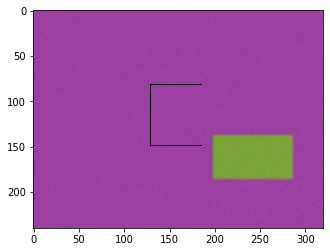

In [139]:
from skimage.draw import rectangle_perimeter

img = imread(path)
rr, cc = rectangle_perimeter((result[1], result[0]), (result[3], result[2]), shape=img.shape)
img[rr, cc] = 1
plt.imshow(img)

Supose for this task possible to use some classical CV algorithms like sobel for edge detecting. 

Benefits:

    much faster
    use only 1 filter(or 2 if we use Gaussian blur before)
    in this task we could detect few rectangles

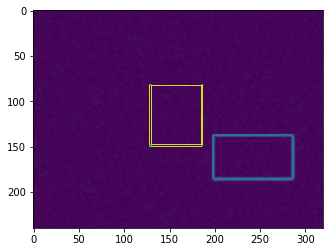

In [143]:
from skimage.filters import sobel

edges = sobel(rgb2gray(img))
plt.imshow(edges)